In [32]:
import os
import pandas as pd
from google.cloud import aiplatform
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
def evaluate_results(data, target, endpt):
    data = data.astype(str)
    X = data.drop(target, axis = 1)
    y = data[target]
    y_pred = pd.Series()
    for i in range(len(data)):
        test = dict(X.iloc[i])
        try:
            results = endpt.predict([test])
            if results[0][0]['scores'][0] > 0.5:
                y_pred[i] = 0
            else:
                y_pred[i] = 1
        except Exception: 
            print(f"Skipping{i}")
            continue
    return y.astype(int), y_pred

In [3]:
def get_stats(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    re = recall_score(y_true, y_pred)
    f = f1_score(y_true, y_pred)
    return [acc, pre, re, f]

In [4]:
kf_endpoint = aiplatform.Endpoint(endpoint_name = 'projects/319407066227/locations/us-east1/endpoints/4942339951225208832')

In [24]:
#get n randomly selected rows from a given set of files 
def get_random_data(n_rows, *files):
    final_data = pd.DataFrame()
    for f in files:
        df = pd.read_csv(f)
        df = df.sample(frac=1).reset_index(drop=True) #shuffle
        rows = df[:n_rows]
        final_data = pd.concat([final_data, rows]).reset_index(drop=True)
    return final_data

In [45]:
#get 50 rows of data from each month of 2016

test_data = get_random_data(100, 'validation_data/kf_test_816.csv',
 'validation_data/kf_test_916.csv',
 'validation_data/kf_test_1016.csv',
 'validation_data/kf_test_1116.csv',
 'validation_data/kf_test_1216.csv')

In [46]:
test_data

,productListName,localProductPrice,type,productPrice,pageviews,is_addtocart,path_depth,page.pagePath,appInfo.screenName,eventInfo.eventCategory,eCommerceAction.step
0,Category,0,EVENT,4790000,17,0,2,/google+redesign/office,shop.googlemerchandisestore.com/google+redesig...,Enhanced Ecommerce,1
1,(not set),0,EVENT,9990000,31,0,2,/google+redesign/bags,shop.googlemerchandisestore.com/google+redesig...,Enhanced Ecommerce,1
2,NaN,0,EVENT,16990000,62,0,1,/home,shop.googlemerchandisestore.com/home,Enhanced Ecommerce,1
3,Category,0,PAGE,97990000,12,0,3,/google+redesign/electronics/quickview,shop.googlemerchandisestore.com/google+redesig...,NaN,1
4,Category,0,EVENT,31990000,41,0,1,/store.html,shop.googlemerchandisestore.com/store.html,Enhanced Ecommerce,1
...,...,...,...,...,...,...,...,...,...,...,...
495,(not set),95990000,PAGE,95990000,57,0,1,/payment.html,shop.googlemerchandisestore.com/payment.html,NaN,2
496,(not set),383920000,PAGE,383920000,64,0,1,/payment.html,shop.googlemerchandisestore.com/payment.html,NaN,2
497,(not set),34990000,EVENT,34990000,13,1,3,/google+redesign/electronics/audio,shop.googlemerchandisestore.com/google+redesig...,Enhanced Ecommerce,1
498,Category,0,EVENT,39990000,19,0,3,/google+redesign/electronics/audio,shop.googlemerchandisestore.com/google+redesig...,Enhanced Ecommerce,1


In [47]:
y_true, y_pred = evaluate_results(test_data, 'is_addtocart', kf_endpoint)
stats = get_stats(y_true, y_pred)
print(f"accuracy: {stats[0]} \nprecision: {stats[1]} \nrecall: {stats[2]} \nf1: {stats[3]}")

accuracy: 0.996 
precision: 0.9753086419753086 
recall: 1.0 
f1: 0.9875


In [48]:
#see results
pd.concat([y_true, y_pred], keys = ["true", "predicted"], axis = 1)

,true,predicted
0,0,0
1,0,1
2,0,0
3,0,0
4,0,0
...,...,...
495,0,0
496,0,0
497,1,1
498,0,0


Text(0.5, 1.0, 'Prediction Results')

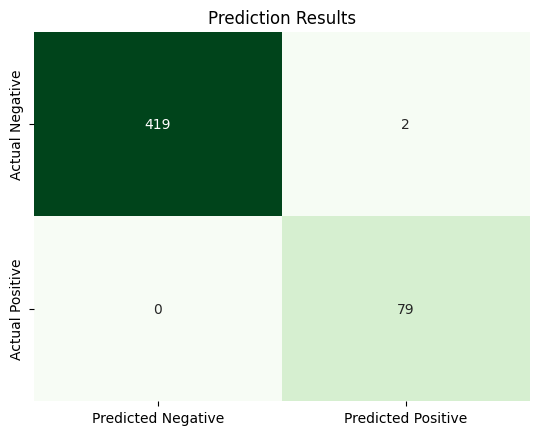

In [49]:
#visualize performance
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Prediction Results")